In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import time  # 用于记录训练时间

# # 1. 加载并预处理数据
# X, y = load_diabetes(return_X_y=True)
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=0
# )

from sklearn.datasets import fetch_california_housing

X, y = fetch_california_housing(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

# 标准化特征和标签（有利于训练稳定与收敛速度）
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_std = X_scaler.fit_transform(X_train)
X_test_std  = X_scaler.transform(X_test)

y_train_std = y_scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_std  = y_scaler.transform(y_test.reshape(-1, 1)).ravel()

# 转成 PyTorch 张量
X_train_t = torch.tensor(X_train_std, dtype=torch.float32)
y_train_t = torch.tensor(y_train_std, dtype=torch.float32).view(-1, 1)
X_test_t  = torch.tensor(X_test_std, dtype=torch.float32)
y_test_t  = torch.tensor(y_test_std, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# 2. 定义线性回归模型（单层线性）
class LinearRegressionModel(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.linear = nn.Linear(in_features, 1)  # y = xW^T + b

    def forward(self, x):
        return self.linear(x)

In [ ]:
# 3. 改进的 AdaMomentum 优化器
# 结合 SGD、Adam、RMSprop 的优势，规避其缺点
class AdaMomentum(torch.optim.Optimizer):
    """
    改进的 AdaMomentum 优化器 - 融合多种优化器的优势
    
    结合的优势：
    1. Adam: 自适应学习率（一阶和二阶矩估计，bias correction）
    2. RMSprop: 对非平稳目标的梯度平方移动平均（更稳定的自适应）
    3. SGD: 训练后期的简单直接更新（更好的泛化性能）
    
    规避的缺点：
    1. Adam 的泛化问题：训练后期逐渐切换到 SGD 风格
    2. RMSprop 的不稳定：结合 Adam 的 bias correction
    3. SGD 的慢收敛：早期使用自适应学习率加速
    """
    def __init__(self, params, lr=1e-3, beta1=0.9, beta2=0.999, 
                 alpha=0.9, momentum=0.9, eps=1e-8, weight_decay=0.0,
                 sgd_switch_ratio=0.7, nesterov=False, total_steps=None):
        """
        Args:
            lr: 学习率
            beta1: Adam 一阶矩衰减率
            beta2: Adam 二阶矩衰减率
            alpha: RMSprop 梯度平方衰减率（类似 beta2，但用于混合计算）
            momentum: SGD 动量系数
            eps: 数值稳定性常数
            weight_decay: L2 正则化系数
            sgd_switch_ratio: 训练进度达到此比例时开始切换到 SGD 风格（0-1）
            nesterov: 是否使用 Nesterov 动量
            total_steps: 总训练步数（用于计算训练进度），如果为 None 则自动估计
        """
        defaults = dict(lr=lr, beta1=beta1, beta2=beta2, alpha=alpha,
                       momentum=momentum, eps=eps, weight_decay=weight_decay,
                       sgd_switch_ratio=sgd_switch_ratio, nesterov=nesterov,
                       total_steps=total_steps)
        super(AdaMomentum, self).__init__(params, defaults)
    
    def step(self, closure=None):
        """执行一步优化"""
        loss = None
        if closure is not None:
            loss = closure()
        
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('AdaMomentum does not support sparse gradients')
                
                # L2 正则化（weight decay）
                if group['weight_decay'] != 0:
                    grad = grad.add(p.data, alpha=group['weight_decay'])
                
                state = self.state[p]
                
                # 初始化状态
                if len(state) == 0:
                    state['step'] = 0
                    # Adam 风格的状态
                    state['exp_avg'] = torch.zeros_like(p.data)  # 一阶矩估计
                    state['exp_avg_sq'] = torch.zeros_like(p.data)  # 二阶矩估计（Adam）
                    # RMSprop 风格的状态
                    state['square_avg'] = torch.zeros_like(p.data)  # RMSprop 的梯度平方平均
                    # SGD 风格的状态
                    state['momentum_buffer'] = torch.zeros_like(p.data)  # SGD 动量缓冲区
                
                exp_avg = state['exp_avg']
                exp_avg_sq = state['exp_avg_sq']
                square_avg = state['square_avg']
                momentum_buffer = state['momentum_buffer']
                
                beta1, beta2 = group['beta1'], group['beta2']
                alpha = group['alpha']
                momentum = group['momentum']
                eps = group['eps']
                sgd_switch_ratio = group['sgd_switch_ratio']
                nesterov = group['nesterov']
                
                state['step'] += 1
                step = state['step']
                
                # 计算训练进度（用于动态切换策略）
                total_steps = group.get('total_steps', None)
                if total_steps is None:
                    # 如果没有提供总步数，使用自适应估计
                    # 基于当前步数动态估计：步数越多，估计的总步数也相应增加
                    estimated_total_steps = max(1000, step * 2)  # 至少是当前步数的 2 倍
                else:
                    estimated_total_steps = total_steps
                
                # 计算原始进度
                if sgd_switch_ratio > 0:
                    # 当达到 switch_ratio 比例时，开始切换到 SGD
                    switch_step = estimated_total_steps * sgd_switch_ratio
                    if step < switch_step:
                        raw_progress = step / switch_step
                    else:
                        # 在 switch_step 之后，进度从 sgd_switch_ratio 线性增长到 1.0
                        remaining_steps = estimated_total_steps - switch_step
                        if remaining_steps > 0:
                            raw_progress = sgd_switch_ratio + (step - switch_step) / remaining_steps * (1.0 - sgd_switch_ratio)
                        else:
                            raw_progress = 1.0
                    raw_progress = min(1.0, raw_progress)
                else:
                    raw_progress = 1.0
                
                # 使用平滑函数，使切换更自然（避免突然变化）
                training_progress = raw_progress ** 0.8  # 稍微平滑，但保持响应性
                
                # ========== Adam 风格的更新 ==========
                # 更新一阶矩估计
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                # 更新二阶矩估计
                exp_avg_sq.mul_(beta2).add_(grad * grad, alpha=1 - beta2)
                
                # Bias correction（Adam 的关键特性）
                bias_correction1 = 1 - beta1 ** step
                bias_correction2 = 1 - beta2 ** step
                
                # ========== RMSprop 风格的更新 ==========
                # RMSprop 使用更激进的梯度平方衰减（alpha 通常接近 1）
                square_avg.mul_(alpha).add_(grad * grad, alpha=1 - alpha)
                
                # ========== 混合自适应学习率计算 ==========
                # 结合 Adam 和 RMSprop 的优势
                # Adam 的 bias-corrected 二阶矩
                adam_denom = (exp_avg_sq.sqrt() / (bias_correction2 ** 0.5)).add_(eps)
                # RMSprop 的梯度平方平均（更稳定）
                rmsprop_denom = square_avg.sqrt().add_(eps)
                
                # 混合两种分母（训练早期更多用 Adam，后期更多用 RMSprop）
                # 使用加权平均，训练早期偏向 Adam，后期偏向 RMSprop
                adam_weight = 1.0 - training_progress * 0.3  # 早期 1.0，后期 0.7
                rmsprop_weight = training_progress * 0.3  # 早期 0.0，后期 0.3
                mixed_denom = adam_weight * adam_denom + rmsprop_weight * rmsprop_denom + (1 - adam_weight - rmsprop_weight) * eps
                
                # 自适应学习率（Adam 风格，带 bias correction）
                adaptive_lr = group['lr'] / bias_correction1
                
                # ========== 动态策略切换 ==========
                # 训练早期：使用 Adam/RMSprop 的自适应机制（快速收敛）
                # 训练后期：逐渐切换到 SGD 风格（更好的泛化）
                sgd_weight = max(0.0, (training_progress - sgd_switch_ratio) / (1.0 - sgd_switch_ratio)) if sgd_switch_ratio < 1.0 else 0.0
                adaptive_weight = 1.0 - sgd_weight
                
                # Adam/RMSprop 风格的更新方向
                adaptive_update = exp_avg / mixed_denom
                
                # SGD 风格的更新方向（带动量）
                if nesterov:
                    # Nesterov 动量：先看未来位置
                    grad_corrected = grad.add(momentum_buffer, alpha=momentum)
                    momentum_buffer.mul_(momentum).add_(grad_corrected)
                    sgd_update = momentum_buffer
                else:
                    # 标准动量
                    momentum_buffer.mul_(momentum).add_(grad)
                    sgd_update = momentum_buffer
                
                # 混合更新方向
                update_direction = adaptive_weight * adaptive_update + sgd_weight * sgd_update
                
                # 应用学习率并更新参数
                p.data.add_(update_direction, alpha=-adaptive_lr)
        
        return loss



# 3. 训练函数：带 L1 正则，返回每一步的 loss 及最终测试表现
def train_model(
    optimizer_name="adam",
    num_epochs=100,
    lr=1e-2,
    l1_lambda=1e-3,   # L1 正则系数
    use_lr_scheduler=False,  # 是否使用学习率调度器
    record_batch_loss=False  # 是否记录每个batch的loss（False则记录每个epoch的平均loss）
):
    # 记录训练开始时间
    start_time = time.time()
    
    in_features = X_train_t.shape[1]
    model = LinearRegressionModel(in_features)

    criterion = nn.MSELoss()

    # 选择优化器
    if optimizer_name.lower() == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    elif optimizer_name.lower() == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name.lower() == "rmsprop":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    elif optimizer_name.lower() == "adamomentum":
        # 计算总训练步数（用于训练进度计算）
        total_batches = len(train_loader) * num_epochs
        # 使用改进的参数配置
        optimizer = AdaMomentum(
            model.parameters(), 
            lr=lr, 
            beta1=0.9,      # Adam 一阶矩衰减率
            beta2=0.999,    # Adam 二阶矩衰减率
            alpha=0.9,      # RMSprop 梯度平方衰减率
            momentum=0.9,   # SGD 动量系数
            eps=1e-8,       # 数值稳定性常数
            weight_decay=0.0,  # L2 正则化（可选）
            sgd_switch_ratio=0.7,  # 训练进度达到 70% 时开始切换到 SGD 风格
            nesterov=False,  # 是否使用 Nesterov 动量
            total_steps=total_batches  # 总训练步数
        )
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    # 学习率调度器（可选）
    scheduler = None
    if use_lr_scheduler:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=50
        )

    # 记录训练 loss（每个epoch的平均loss或每个batch的loss）
    train_losses = []
    epoch_avg_losses = []  # 每个epoch的平均loss

    global_step = 0
    for epoch in range(num_epochs):
        model.train()
        epoch_losses = []  # 当前epoch的所有batch loss
        
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            mse_loss = criterion(preds, yb)

            # L1 正则
            l1_reg = 0.0
            for param in model.parameters():
                l1_reg = l1_reg + torch.sum(torch.abs(param))

            loss = mse_loss + l1_lambda * l1_reg

            loss.backward()
            
            # 梯度裁剪（防止梯度爆炸）
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()

            batch_loss = loss.item()
            epoch_losses.append(batch_loss)
            
            if record_batch_loss:
                train_losses.append(batch_loss)
            
            global_step += 1

        # 计算当前epoch的平均loss
        epoch_avg_loss = np.mean(epoch_losses)
        epoch_avg_losses.append(epoch_avg_loss)
        
        if not record_batch_loss:
            train_losses.append(epoch_avg_loss)
        
        # 更新学习率（如果使用调度器）
        if scheduler is not None:
            scheduler.step(epoch_avg_loss)

        # 每个 epoch 打印一下
        if (epoch + 1) % max(1, (num_epochs // 5)) == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"[{optimizer_name.upper()}] Epoch {epoch+1}/{num_epochs}, "
                  f"Avg loss: {epoch_avg_loss:.4f}, LR: {current_lr:.6f}")

    # 评估
    model.eval()
    with torch.no_grad():
        y_test_pred_std = model(X_test_t).cpu().numpy().ravel()

    y_test_pred = y_scaler.inverse_transform(
        y_test_pred_std.reshape(-1, 1)
    ).ravel()

    mse = mean_squared_error(y_test, y_test_pred)
    r2  = r2_score(y_test, y_test_pred)
    
    # 记录训练结束时间
    end_time = time.time()
    training_time = end_time - start_time

    print(f"\n[{optimizer_name.upper()}] Test MSE (original): {mse:.4f}")
    print(f"[{optimizer_name.upper()}] Test R^2: {r2:.4f}")
    print(f"[{optimizer_name.upper()}] Training time: {training_time:.2f} seconds")

    return model, train_losses, mse, r2, training_time

In [8]:
# Jupyter 直接运行：无 main 函数
# 统一训练配置
NUM_EPOCHS = 200
L1_LAMBDA = 1e-3

# 降低学习率以减少震荡（原来1e-2太大）
optimizers = {
    "SGD":   {"optimizer_name": "sgd",    "lr": 1e-3},      # 从 1e-2 降到 1e-3
    "Adam":  {"optimizer_name": "adam",   "lr": 1e-3},      # 从 1e-2 降到 1e-3
    "RMSprop": {"optimizer_name": "rmsprop", "lr": 1e-3},   # 从 1e-2 降到 1e-3
    "AdaMomentum": {"optimizer_name": "adamomentum", "lr": 1e-3},  # 创新的优化器
}

all_train_losses = {}
test_mse_results = {}
test_r2_results = {}
training_times = {}  # 记录训练时间
stability_metrics = {}  # 记录稳定性指标

# 4. 训练并收集结果
for opt_name, cfg in optimizers.items():
    print(f"\n=== Training with {opt_name} ===")
    model, losses, mse, r2, train_time = train_model(
        optimizer_name=cfg["optimizer_name"],
        num_epochs=NUM_EPOCHS,
        lr=cfg["lr"],
        l1_lambda=L1_LAMBDA,
        use_lr_scheduler=False,      # 启用学习率调度器
        record_batch_loss=False     # 记录每个epoch的平均loss，而不是每个batch的loss
    )
    all_train_losses[opt_name] = losses
    test_mse_results[opt_name] = mse
    test_r2_results[opt_name] = r2
    training_times[opt_name] = train_time
    
    # 计算稳定性指标
    losses_array = np.array(losses)
    # 使用后半段训练期的loss来计算稳定性（排除初始不稳定阶段）
    stable_period_start = len(losses) // 2
    stable_losses = losses_array[stable_period_start:]
    
    loss_std = np.std(stable_losses)  # 标准差（越小越稳定）
    loss_cv = loss_std / np.mean(stable_losses)  # 变异系数（越小越稳定）
    loss_range = np.max(stable_losses) - np.min(stable_losses)  # 波动范围（越小越稳定）
    
    stability_metrics[opt_name] = {
        'std': loss_std,
        'cv': loss_cv,
        'range': loss_range
    }
    
    print(f"[{opt_name}] Stability - Std: {loss_std:.6f}, CV: {loss_cv:.6f}, Range: {loss_range:.6f}")



=== Training with SGD ===
[SGD] Epoch 40/200, Avg loss: 0.4567, LR: 0.001000
[SGD] Epoch 80/200, Avg loss: 0.4210, LR: 0.001000
[SGD] Epoch 120/200, Avg loss: 0.4087, LR: 0.001000
[SGD] Epoch 160/200, Avg loss: 0.4048, LR: 0.001000
[SGD] Epoch 200/200, Avg loss: 0.4014, LR: 0.001000

[SGD] Test MSE (original): 0.5919
[SGD] Test R^2: 0.5460
[SGD] Training time: 22.33 seconds
[SGD] Stability - Std: 0.003587, CV: 0.008845, Range: 0.013820

=== Training with Adam ===
[ADAM] Epoch 40/200, Avg loss: 0.4012, LR: 0.001000
[ADAM] Epoch 80/200, Avg loss: 0.3998, LR: 0.001000
[ADAM] Epoch 120/200, Avg loss: 0.3976, LR: 0.001000
[ADAM] Epoch 160/200, Avg loss: 0.3986, LR: 0.001000
[ADAM] Epoch 200/200, Avg loss: 0.3991, LR: 0.001000

[ADAM] Test MSE (original): 0.5853
[ADAM] Test R^2: 0.5511
[ADAM] Training time: 23.25 seconds
[Adam] Stability - Std: 0.001090, CV: 0.002732, Range: 0.006062

=== Training with RMSprop ===
[RMSPROP] Epoch 40/200, Avg loss: 0.4014, LR: 0.001000
[RMSPROP] Epoch 80/200

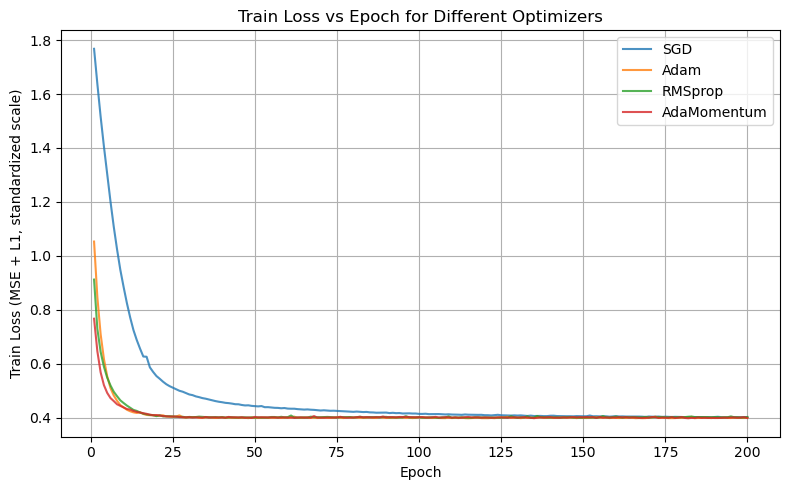

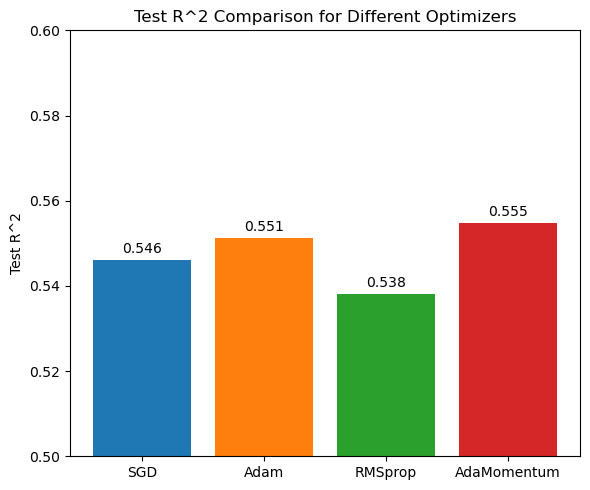

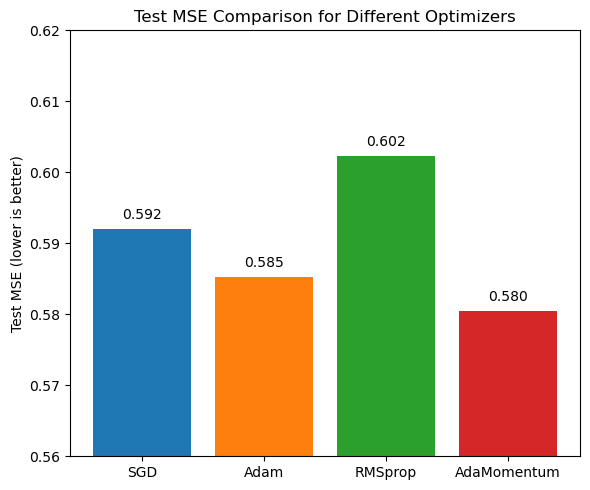

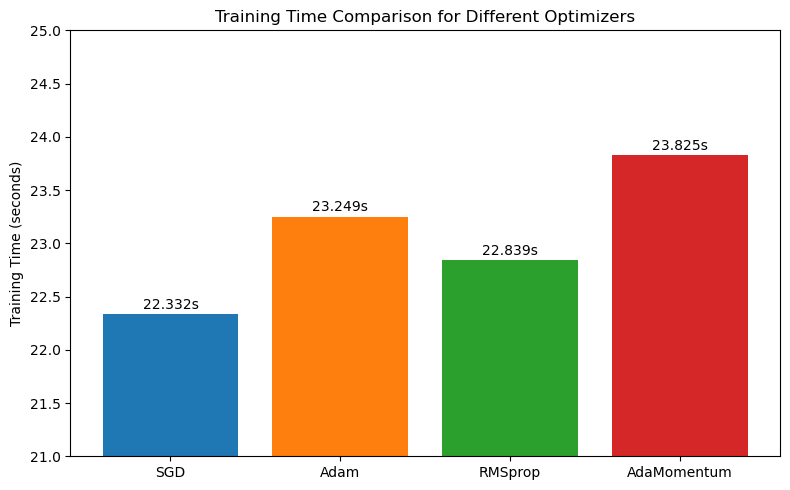

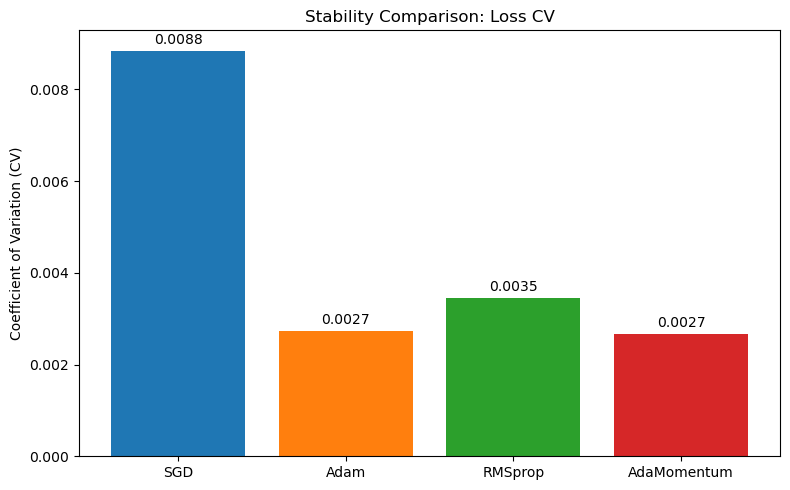

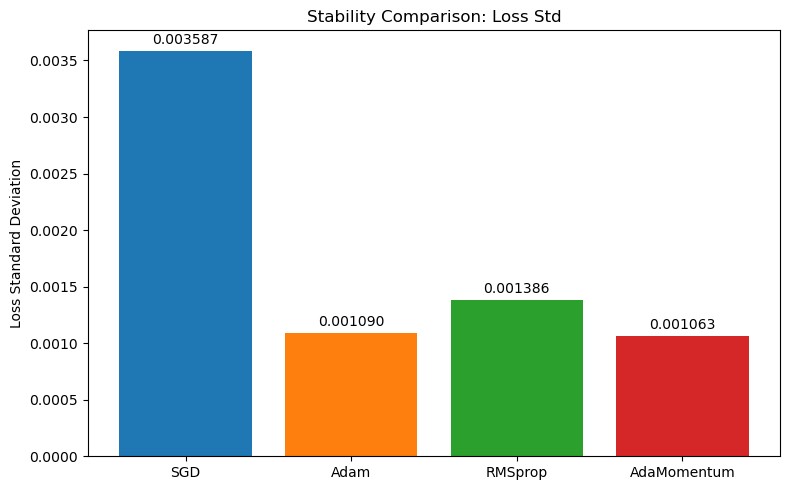

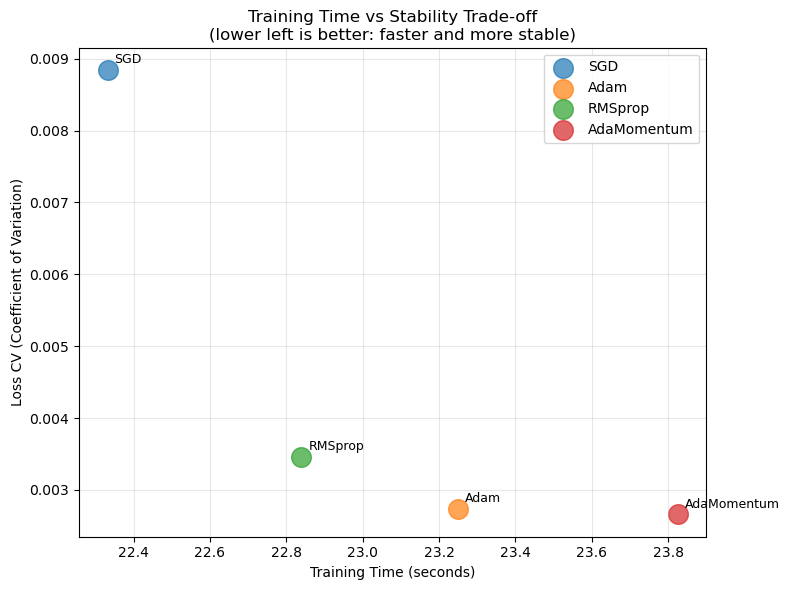


综合对比表
Optimizer       Time(s)      Loss Std     Loss CV      Test R²    Test MSE  
--------------------------------------------------------------------------------
SGD             22.33        0.003587     0.008845     0.5460     0.5919    
Adam            23.25        0.001090     0.002732     0.5511     0.5853    
RMSprop         22.84        0.001386     0.003456     0.5381     0.6023    
AdaMomentum     23.82        0.001063     0.002657     0.5548     0.5805    


In [29]:
# 5. 画 train loss vs epoch 曲线（现在记录的是每个epoch的平均loss）
plt.figure(figsize=(8, 5))
for opt_name, losses in all_train_losses.items():
    epochs = np.arange(1, len(losses) + 1)
    plt.plot(epochs, losses, label=opt_name, alpha=0.8)

plt.xlabel("Epoch")
plt.ylabel("Train Loss (MSE + L1, standardized scale)")
plt.title("Train Loss vs Epoch for Different Optimizers")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. 画最终 test R^2 的比较柱状图（可以看作“accuracy”类指标，越大越好）
plt.figure(figsize=(6, 5))
opt_names = list(test_r2_results.keys())
r2_values = [test_r2_results[name] for name in opt_names]

x = np.arange(len(opt_names))
colors = ["C0", "C1", "C2", "C3"]  # 添加第四个颜色用于新优化器
plt.bar(x, r2_values, color=colors[:len(opt_names)])
plt.xticks(x, opt_names)
plt.ylabel("Test R^2")
plt.ylim(0.5, 0.6)  # 纵坐标区间设置为0.5到0.6
plt.title("Test R^2 Comparison for Different Optimizers")
for i, v in enumerate(r2_values):
    plt.text(i, v + 0.001, f"{v:.3f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()

# 如果你更想看 MSE 也可以加一个 MSE 柱状图：
plt.figure(figsize=(6, 5))
mse_values = [test_mse_results[name] for name in opt_names]
plt.bar(x, mse_values, color=colors[:len(opt_names)])
plt.xticks(x, opt_names)
plt.ylabel("Test MSE (lower is better)")
plt.ylim(0.56, 0.62)  # 纵坐标区间设置为0.5到0.6
plt.title("Test MSE Comparison for Different Optimizers")
for i, v in enumerate(mse_values):
    plt.text(i, v + 0.001, f"{v:.3f}", ha="center", va="bottom", rotation=0)
plt.tight_layout()
plt.show()

# 7. 训练时间比较图
plt.figure(figsize=(8, 5))
time_values = [training_times[name] for name in opt_names]
plt.bar(x, time_values, color=colors[:len(opt_names)])
plt.xticks(x, opt_names)
plt.ylabel("Training Time (seconds)")
plt.ylim(21, 25)  # 纵坐标区间设置为0.5到0.6
plt.title("Training Time Comparison for Different Optimizers")
for i, v in enumerate(time_values):
    plt.text(i, v + max(time_values)*0.001, f"{v:.3f}s", ha="center", va="bottom")
plt.tight_layout()
plt.show()

# 8. 稳定性比较图（使用变异系数 CV，越小越稳定）
plt.figure(figsize=(8, 5))
cv_values = [stability_metrics[name]['cv'] for name in opt_names]
plt.bar(x, cv_values, color=colors[:len(opt_names)])
plt.xticks(x, opt_names)
plt.ylabel("Coefficient of Variation (CV)")
plt.title("Stability Comparison: Loss CV")
for i, v in enumerate(cv_values):
    plt.text(i, v + max(cv_values)*0.01, f"{v:.4f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()

# 9. 稳定性比较图（使用标准差，越小越稳定）
plt.figure(figsize=(8, 5))
std_values = [stability_metrics[name]['std'] for name in opt_names]
plt.bar(x, std_values, color=colors[:len(opt_names)])
plt.xticks(x, opt_names)
plt.ylabel("Loss Standard Deviation")
plt.title("Stability Comparison: Loss Std")
for i, v in enumerate(std_values):
    plt.text(i, v + max(std_values)*0.01, f"{v:.6f}", ha="center", va="bottom")
plt.tight_layout()
plt.show()

# 10. 综合对比图：训练时间 vs 稳定性（散点图）
plt.figure(figsize=(8, 6))
for i, opt_name in enumerate(opt_names):
    plt.scatter(training_times[opt_name], stability_metrics[opt_name]['cv'], 
                s=200, color=colors[i], label=opt_name, alpha=0.7)
    plt.annotate(opt_name, 
                (training_times[opt_name], stability_metrics[opt_name]['cv']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.xlabel("Training Time (seconds)")
plt.ylabel("Loss CV (Coefficient of Variation)")
plt.title("Training Time vs Stability Trade-off\n(lower left is better: faster and more stable)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 11. 打印综合对比表格
print("\n" + "="*80)
print("综合对比表")
print("="*80)
print(f"{'Optimizer':<15} {'Time(s)':<12} {'Loss Std':<12} {'Loss CV':<12} {'Test R²':<10} {'Test MSE':<10}")
print("-"*80)
for opt_name in opt_names:
    print(f"{opt_name:<15} {training_times[opt_name]:<12.2f} "
          f"{stability_metrics[opt_name]['std']:<12.6f} "
          f"{stability_metrics[opt_name]['cv']:<12.6f} "
          f"{test_r2_results[opt_name]:<10.4f} "
          f"{test_mse_results[opt_name]:<10.4f}")
print("="*80)